<a href="https://colab.research.google.com/github/AzitaKalantar/NLP-Projects/blob/main/Sentiment%20and%20Emotion%20Detector%20using%20ISEAR%20dataset/version3_BERT_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Transformer for MultiClass Text Classification

In [51]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
# Importing the libraries needed

from torch.nn import functional as F

import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [53]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import pandas as pd
train_data = pd.read_csv('drive/My Drive/Data/ISEAR/pre_processsed_data_train.csv')
test_data = pd.read_csv('drive/My Drive/Data/ISEAR/pre_processsed_data_test.csv')
train_data.drop(train_data.columns[0],axis=1,inplace=True)
test_data.drop(test_data.columns[0],axis=1,inplace=True)

In [56]:
from sklearn.preprocessing import LabelBinarizer
ohe = LabelBinarizer()
ohe.fit(train_data['Emotion'])
encoded_train = pd.DataFrame(ohe.transform(train_data['Emotion']))
encoded_test = pd.DataFrame(ohe.transform(test_data['Emotion']))

In [57]:
train_data['Encoded_Emotion'] = encoded_train.values.tolist()
test_data['Encoded_Emotion'] = encoded_test.values.tolist()

In [58]:

test_data.head()

,Emotion,Text,Encoded_Emotion
0,sadness,experienc emot grandfath pass away.,"[0, 0, 0, 0, 1]"
1,neutral,"first move , walk everywher . within week , pu...","[0, 0, 0, 1, 0]"
2,anger,"` oh ! "" belat , voic high rather indign .","[1, 0, 0, 0, 0]"
3,fear,"howev , right hon. gentleman recognis profound...","[0, 1, 0, 0, 0]"
4,sadness,boyfriend turn promis coming.,"[0, 0, 0, 0, 1]"


In [59]:
# Defining some key variables that will be used later on in the training
# MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 5
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#embedding_size=100
#rnn_hidden_size=64
#val_ratio = 0.15

In [60]:
class Dataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        measure_len = lambda text: len(text.split(" "))
        self.max_len = max(map(measure_len, dataframe.Text))
        self.comment_text = dataframe.Text
        self.targets = self.data.Encoded_Emotion
        
    def __getitem__(self, index):
        text = str(self.data.Text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.data.Encoded_Emotion[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [61]:
training_set = Dataset(train_data, tokenizer)
testing_set = Dataset(test_data, tokenizer)
#val_set = Dataset(val_data, tokenizer)

In [62]:

#val_dataloader = DataLoader(val_set, batch_size=VALID_BATCH_SIZE, shuffle=True,drop_last=True)
train_dataloader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True,drop_last=True)
test_dataloader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=True,drop_last=True)



In [63]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 5)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids,return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [64]:
model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [65]:
# Creating the loss function and optimizer
#loss_function = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [66]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [67]:
train_loss= []
val_loss= []
smalles_loss = float('inf')
for epoch in range(EPOCHS):
  running_loss = 0.0
  model.train()
  for batch_index, data in enumerate(train_dataloader):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.long)
      optimizer.zero_grad()
      outputs = model(ids, mask, token_type_ids)
      loss = loss_fn(outputs, targets.float())
      running_loss += (loss.item() - running_loss) / (batch_index + 1)
      loss.backward()
      # # When using GPU
      optimizer.step()
  train_loss.append(running_loss)
  running_loss = 0.
  model.eval()
  for batch_index,data in enumerate(test_dataloader):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.long)
    outputs = model(ids, mask, token_type_ids )
    loss = loss_fn(outputs, targets.float())
    running_loss += (loss.item() - running_loss) / (batch_index + 1)
  val_loss.append(running_loss)
  #saving the best model we have so far
  if running_loss < smalles_loss :
    torch.save(model.state_dict(),"drive/My Drive/Data/ISEAR/model_v3")
    smalles_loss = running_loss
  print(epoch)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0
1
2
3
4


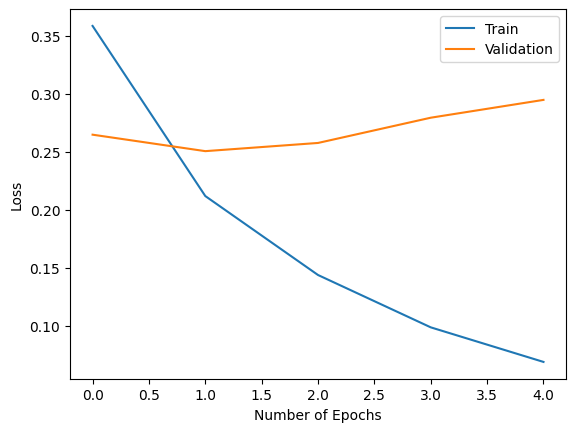

In [68]:
import matplotlib.pyplot as plt
plot1, = plt.plot(train_loss)
plot2, = plt.plot(val_loss)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend([plot1,plot2],["Train", "Validation"])
plt.show()

In [69]:
# we load the best model we had during training process
model.load_state_dict(torch.load("drive/My Drive/Data/ISEAR/model_v3"))

<All keys matched successfully>

In [70]:
fin_targets =[]
fin_outputs = []
model.eval()
for batch_index,data in enumerate(test_dataloader):
  ids = data['ids'].to(device, dtype = torch.long)
  mask = data['mask'].to(device, dtype = torch.long)
  token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
  targets = data['targets'].to(device, dtype = torch.long)
  outputs = model(ids, mask, token_type_ids )
  fin_targets.extend(targets.cpu().detach().numpy().tolist())
  fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
outputs = fin_outputs
targets = fin_targets
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
  

Accuracy Score = 0.7122641509433962
F1 Score (Micro) = 0.7510328997704668
F1 Score (Macro) = 0.7509214441307762
